<a href="https://colab.research.google.com/github/Nuri-Tas/NLP/blob/main/Text%20Classification/Sentiment_Analysis_with_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [233]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

import matplotlib.pyplot as plt

# Basic EDA and Preprocessing

Load data

In [234]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

File ‘AirlineTweets.csv’ already there; not retrieving.



In [235]:
df = pd.read_csv("/content/AirlineTweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We are mainly interested in `text` and `airline_sentiment` columns. Additionally, remove `@` symbol with the username and lower characters. I intentionally avoid removing punctuation characters as I believe punctuation could be helpful in distinguishing sentences. 

In [236]:
df = df[["airline_sentiment", "text"]]

# remove username with @ symbol and lower characters
df["text"] = df["text"].replace("\@\S+", "", regex=True).str.lower()
df.head()

,airline_sentiment,text
0,neutral,what said.
1,positive,plus you've added commercials to the experien...
2,neutral,i didn't today... must mean i need to take an...
3,negative,"it's really aggressive to blast obnoxious ""en..."
4,negative,and it's a really big bad thing about it


Most of the text have negative sentiments, whereas the rest have slightly higher neutral text.

<Axes: >

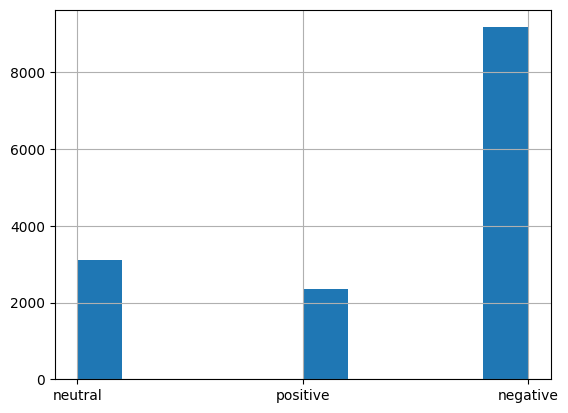

In [237]:
df["airline_sentiment"].hist()

In [238]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["airline_sentiment"], test_size=0.2)

We will build tf-idf that will take into account only unigrams:

In [239]:
tfidf = TfidfVectorizer(ngram_range=(1,1))
train_tfidf = tfidf.fit_transform(X_train)
test_tfidf = tfidf.transform(X_test)

In [240]:
train_tfidf.shape

(11712, 12528)

# Build model

In [241]:
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(train_tfidf, y_train)
predictions = log_reg.predict(test_tfidf)

Check classes and their interception points:

In [242]:
log_reg.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [243]:
log_reg.intercept_

array([ 0.09300933,  0.52374609, -0.61675542])

The shape of the coefficient of logistic regression model should be K x V - unless the test set is binary - where K is the number of classes and V is the dictionary size, i.e. 12567.

In [244]:
log_reg.coef_.shape

(3, 12528)

# Metrics

First, check out the confusion matrix. We can observe the model generally mislabeled a large portion of neutral and positive text. In both cases, most of the wrong labeled texts are interpreted as negative.

In [245]:
confused_matrix = confusion_matrix(y_test, predictions)
confused_matrix

array([[1786,   83,   26],
       [ 254,  298,   31],
       [ 126,   55,  269]])

Macro f1 score:

In [246]:
all_f1 = 0
for i in range(3):
  p = confused_matrix[i, i] / sum(confused_matrix[:, i])
  r = confused_matrix[i, i] / sum(confused_matrix[i, :])
  all_f1 += 2*p*r/(p+r)

print("Macro f1 score:", all_f1 / 3)

Macro f1 score: 0.7192574740407268


Micro f1 score:

In [247]:
f1_score(y_test, predictions, average="micro")

0.8036202185792349

ROC-AUC scores. We calculate roc-auc for both one vs one and one vs rest cases.

In [248]:
# one vs one
probs = log_reg.predict_proba(test_tfidf)
print(roc_auc_score(y_test, probs, multi_class="ovo"))

0.890843713683859


In [249]:
# one vs rest
print(roc_auc_score(y_test, probs, multi_class="ovr"))

0.9045026778908523


# Logistic Regression for Binary Classification

We'll now build a LR model to distinguish only positive and negative texts:

In [250]:
binary_df = df[df["airline_sentiment"].isin(["positive", "negative"])]
binary_df.head()

,airline_sentiment,text
1,positive,plus you've added commercials to the experien...
3,negative,"it's really aggressive to blast obnoxious ""en..."
4,negative,and it's a really big bad thing about it
5,negative,seriously would pay $30 a flight for seats th...
6,positive,"yes, nearly every time i fly vx this “ear wor..."


In [251]:
X_train, X_test, y_train, y_test = train_test_split(binary_df["text"], binary_df["airline_sentiment"], test_size=0.2)

In [252]:
tfidf = TfidfVectorizer(max_features=2000)
train_vectors = tfidf.fit_transform(X_train)
test_vectors = tfidf.transform(X_test)

In [253]:
tfidf.get_feature_names_out().shape

(2000,)

In [254]:
model = LogisticRegression(max_iter=500)
model.fit(train_vectors, y_train)
preds = model.predict(test_vectors)

Unlike multiclass problems, the coefficients' shape must be (1, V), where V is the vocabulary size. However, as we restricted the maximum number of vocabulary size to 2000 in our case.

In [255]:
model.coef_.shape

(1, 2000)

Get the distribution of the model's weights. We can see the weights are slightly skewed towards negative values, that is words tend to indicate a text doesn't belong to the true class.

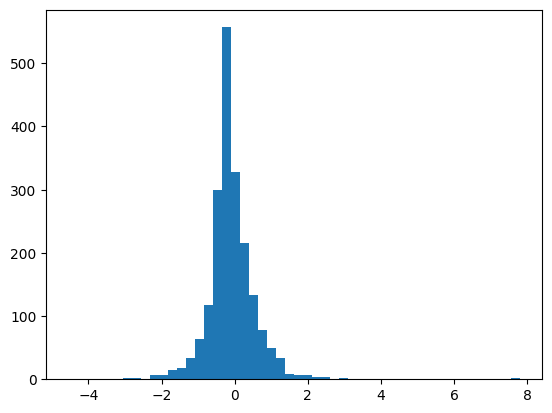

In [256]:
plt.hist(model.coef_[0], bins=50);

Show some words whose weights are smaller than -2. 

In [257]:
for word, idx in tfidf.vocabulary_.items():
  if model.coef_[0][idx] < -2:
    print(word, model.coef_[0][idx])

why -2.245234463994645
not -4.542558717614767
is -2.088800723904155
no -4.137410751204038
what -2.2288705026142988
don -2.3186547767622305
cancelled -2.7124593782951085
delayed -2.9364591682426044
hours -3.352533354689956
rude -2.0701035244826698
nothing -2.7343100278913837
call -2.062356635593247
hour -2.213858980443692
worst -3.097352011918219
how -2.11533686890168
hold -2.84223593013757


# Metrics for Binary Classification

In [258]:
confusion_matrix(y_test, preds)

array([[1795,   18],
       [ 212,  284]])

In [259]:
micro_f1 = f1_score(y_test, preds, average="micro")
print(f"The micro f1 score is {micro_f1} ")

The micro f1 score is 0.9003897791251624 


In [260]:
macro_f1 = f1_score(y_test, preds, average="macro")
print(f"The macro f1 score is {macro_f1} ")

The macro f1 score is 0.8257850122688921 


Print class names to see the corresponding index for each class. We will also get the roc-auc score for positive class as negative texts are already overrepresented.

In [261]:
model.classes_

array(['negative', 'positive'], dtype=object)

In [262]:
binary_probs = model.predict_proba(test_vectors)[:, 0]
print(f"The ROC-AUC score for positive texts are {roc_auc_score(y_test, binary_probs)} ")

The ROC-AUC score for positive texts are 0.050048484956319056 
